In [103]:
import pandas as pd
#from GitHub repository
url = "https://raw.githubusercontent.com/robynhathaway/RPDA-PHC-Project/refs/heads/main/PHC_Project_Dataset.csv"
df = pd.read_csv(url)
# df.head()

In [104]:
#updated name to improve consistency in code
df = df.rename(columns={"Distance_PHC (km)": "Distance_PHC_km"})

#log-transform Distance_PHC_km
from sklearn.preprocessing import StandardScaler
import numpy as np

df["log_Distance_PHC_km"] = np.log1p(df["Distance_PHC_km"])
scaler = StandardScaler()
df["log_Distance_PHC_km"] = scaler.fit_transform(df[["log_Distance_PHC_km"]])

In [105]:
#model specification

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

df = df.copy()

# --- Outcome: PHC workload ---
df['Workload'] = df['PHC_Headcount'] / df['Population']
df = df[np.isfinite(df['Workload']) & (df['Workload'] > 0)].copy()
df['log_Workload'] = np.log(df['Workload'])

# --- Digital Readiness composite ---
digital_cols = [
    'StatsSA_Households_MobileInt (%)',
    'StatsSA_Households_LandCell (%)',
    'StatsSA_Households_PubWIFI (%)',
    'StatsSA_Households_AnyIntAccess (%)'
]

comp = df[digital_cols].astype(float)
comp_z = (comp - comp.mean()) / comp.std(ddof=1)
df['Digital_Readiness'] = comp_z.mean(axis=1)

# --- Standardise continuous predictors (Z-scores) ---
scaler = StandardScaler()

for col in [
    'Digital_Readiness',
    'Med_Pracs_per100k',
    'PHC_Facilities_Total',
    'PHC_Expend_per_capita',
    'Household_Size',
    'log_Distance_PHC_km'
]:
    df[col] = scaler.fit_transform(df[[col]])

# Area_Classification as string (Urban, Semi-Urban, Rural)
df['Area_Classification'] = df['Area_Classification'].astype(str)

# --- Model formula: fixed effects (NO year fixed effects now) ---
formula = (
    "log_Workload ~ Digital_Readiness "
    "* C(Area_Classification, Treatment(reference='Urban')) "
    "+ Med_Pracs_per100k + PHC_Facilities_Total "
    "+ PHC_Expend_per_capita + Household_Size "
    "+ log_Distance_PHC_km"
)

# Data used in model
model_df = df[['log_Workload', 'Digital_Readiness', 'Med_Pracs_per100k',
               'PHC_Facilities_Total', 'PHC_Expend_per_capita',
               'Household_Size', 'log_Distance_PHC_km',
               'Area_Classification', 'Province']].dropna().copy()

# --- Mixed model: random intercept + random slope for Digital_Readiness ---
model = smf.mixedlm(
    formula=formula,
    data=model_df,
    groups=model_df["Province"],
    re_formula="~ Digital_Readiness"   # random slope by Province
)

result = model.fit(reml=True, method="lbfgs", maxiter=200)
print(result.summary())



                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        log_Workload
No. Observations:                        156                            Method:                                    REML        
No. Groups:                              9                              Scale:                                     0.0280      
Min. group size:                         9                              Log-Likelihood:                            15.8046     
Max. group size:                         33                             Converged:                                 Yes         
Mean group size:                         17.3                                                                                  
-------------------------------------------------------------------------------------------------------------------------------
                     

In [106]:
# Separate ML refit for model fit indices (AIC/BIC)
result_ml = model.fit(reml=False, method="lbfgs", maxiter=200)

print("\nModel Fit Statistics (ML)")
print("----------------------------")
print(f"AIC: {result_ml.aic:.2f}")
print(f"BIC: {result_ml.bic:.2f}")
print(f"Log-Likelihood: {result_ml.llf:.2f}")



Model Fit Statistics (ML)
----------------------------
AIC: -50.90
BIC: -5.16
Log-Likelihood: 40.45


In [107]:
# Model Diagnostics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# check for multicollinearity (VIFs)
X = model_df[['Digital_Readiness','Med_Pracs_per100k','PHC_Expend_per_capita',
              'Household_Size','log_Distance_PHC_km']]
X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

                Variable       VIF
0                  const  1.000000
1      Digital_Readiness  1.858434
2      Med_Pracs_per100k  1.493610
3  PHC_Expend_per_capita  2.234643
4         Household_Size  1.271949
5    log_Distance_PHC_km  1.048655


/Users/RobynH/Desktop/Varsity VC Code/Research_Project/venv/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


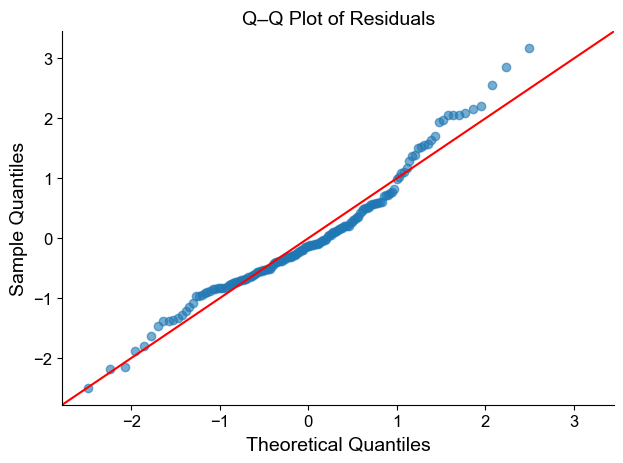

In [108]:
# residual normality Q-Q plot

import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"

resid = result.resid
fig = sm.qqplot(resid, line="45", fit=True, color="#2B6CB0", alpha=0.6)

ax = plt.gca()
ax.set_facecolor("white")
ax.grid(False)

ax.set_title("Q–Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=14)
ax.set_ylabel("Sample Quantiles", fontsize=14)

for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


In [109]:
# Durban Watson
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(resid)
print(f"Durbin–Watson: {dw:.2f}")  # ~2 is good (no autocorrelation)


Durbin–Watson: 1.33


In [110]:
#Marginal and Conditional R squared

import numpy as np
import pandas as pd

# Fixed-effects linear predictor variance: Var(X beta)
X = result.model.exog                # fixed-effects design matrix used in the fit
beta = result.fe_params.values
var_fix = np.var(X @ beta, ddof=1)

# Residual variance (sigma^2)
var_resid = result.scale

# Random-effects variance components
# Statsmodels MixedLM stores RE variances in cov_re; residual scale in result.scale
cov_re = result.cov_re               # DataFrame; intercept at [0,0]
var_intercept = float(cov_re.iloc[0, 0]) if cov_re is not None else 0.0

# Optionally include random slope variance if present (small in your model)
var_slope = 0.0
if cov_re is not None and cov_re.shape[0] > 1:
    var_slope = float(cov_re.iloc[1, 1])

# Following Nakagawa & Schielzeth (2013) for (mostly) intercept models:
var_random = var_intercept + var_slope  # slope term is ~0 in your fit
var_total  = var_fix + var_random + var_resid

R2_marginal    = var_fix / var_total
R2_conditional = (var_fix + var_random) / var_total

print(f"Marginal R^2 (fixed):     {R2_marginal:.3f}")
print(f"Conditional R^2 (fixed+RE): {R2_conditional:.3f}")


Marginal R^2 (fixed):     0.084
Conditional R^2 (fixed+RE): 0.861


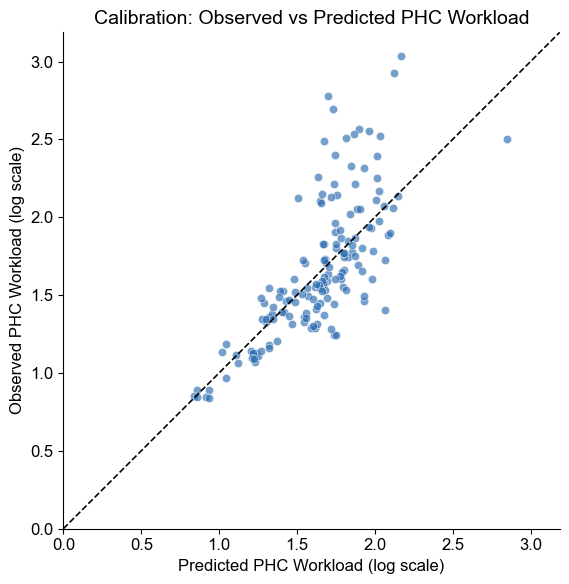

In [111]:
# Model Calibration
import numpy as np
import matplotlib.pyplot as plt

# Extract fitted and observed (on log scale)
fitted_log = result.fittedvalues
obs_log = model_df["log_Workload"]

# Convert back to original scale
predicted = np.exp(fitted_log)
observed = np.exp(obs_log)

# --- Plot ---
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"
ax = plt.gca()
ax.set_facecolor("white")

# Scatter plot
plt.scatter(predicted, observed,
            alpha=0.65,
            color="#2B6CB0",
            edgecolor="white",
            linewidth=0.5)

# Ensure equal aspect ratio for 45° line
mx = max(predicted.max(), observed.max()) * 1.05
plt.plot([0, mx], [0, mx], color="black", linestyle="--", linewidth=1.2)
plt.xlim(0, mx)
plt.ylim(0, mx)
ax.set_aspect('equal', adjustable='box')

# Labels and title

plt.xlabel("Predicted PHC Workload (log scale)")
plt.ylabel("Observed PHC Workload (log scale)")
plt.title("Calibration: Observed vs Predicted PHC Workload")

# Style
ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


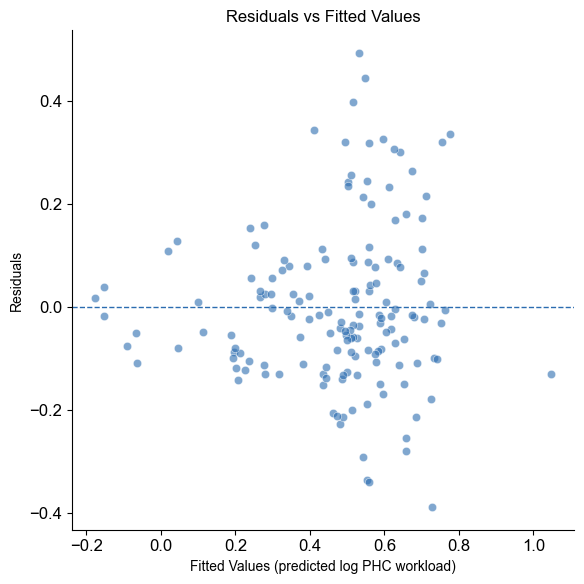

In [112]:
#residuals vs fitted values

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"

ax = plt.gca()
ax.set_facecolor("white")

plt.scatter(result.fittedvalues, result.resid, alpha=0.6,
            color="#2B6CB0", edgecolor="white", linewidth=0.5)
plt.axhline(0, color="#2B6CB0", linestyle="--", linewidth=1)

plt.title("Residuals vs Fitted Values", fontsize=12)
plt.xlabel("Fitted Values (predicted log PHC workload)", fontsize=10)
plt.ylabel("Residuals", fontsize=10)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


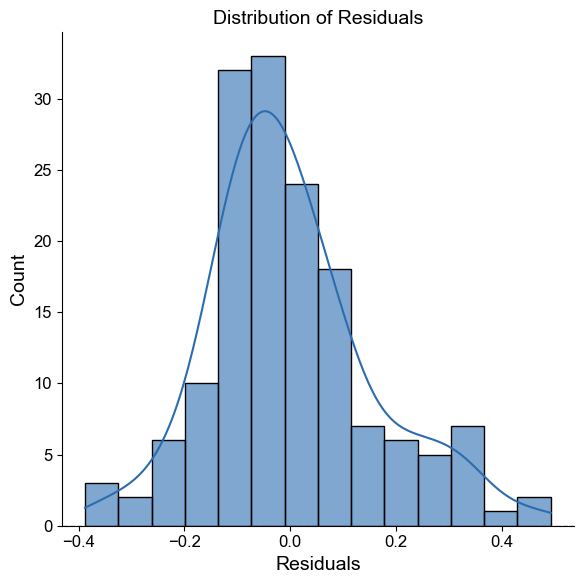

In [113]:
# Distribution of Residuals

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"

ax = plt.gca()
ax.set_facecolor("white")

sns.histplot(result.resid, kde=True, color="#2B6CB0", alpha=0.6, ax=ax)
plt.axhline(0, color="#2B6CB0", linestyle="--", linewidth=1)

plt.title("Distribution of Residuals", fontsize=14)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Count", fontsize=14)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


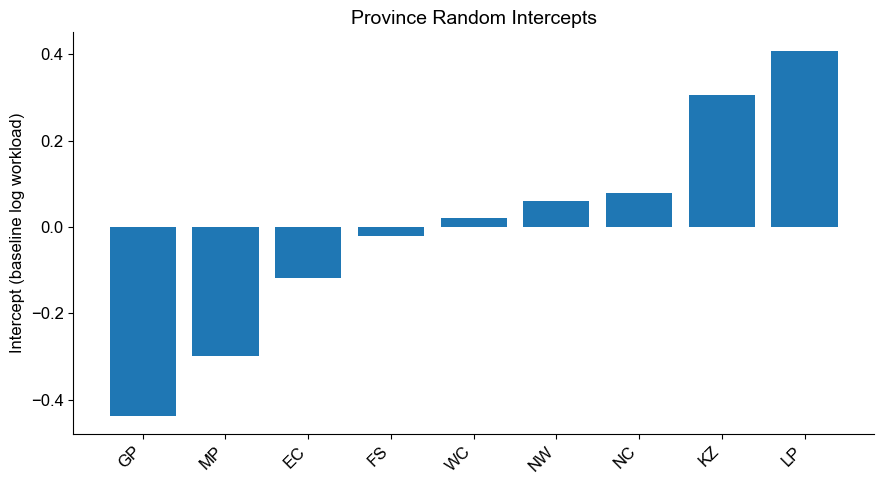

In [114]:
# Results/ Visualisations:
# province random intercepts

# Convert random effects dict to DataFrame
re = pd.DataFrame.from_dict(result.random_effects, orient='index')
re.index.name = 'Province'
re = re.reset_index()

# Statsmodels often names the intercept 'Intercept' or 'const'
intercept_cols = [c for c in re.columns if c.lower() in ['intercept','const']]
slope_cols = [c for c in re.columns if 'Digital_Readiness' in c]

# Fallback if names are odd
if not intercept_cols:
    intercept_cols = [re.columns[1]]
if not slope_cols and re.shape[1] >= 3:
    slope_cols = [re.columns[2]]


# Bar plot of random intercepts by province
plt.figure(figsize=(9,5))
re_sorted = re.sort_values(intercept_cols[0])
plt.bar(re_sorted['Province'], re_sorted[intercept_cols[0]])
plt.title("Province Random Intercepts")
plt.ylabel("Intercept (baseline log workload)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




/var/folders/sx/tjm_f_z14l9g4lrl4d42h0xc0000gp/T/ipykernel_9868/1736834604.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_low_fixed = float(result.predict(row_low))     # fixed effects
/var/folders/sx/tjm_f_z14l9g4lrl4d42h0xc0000gp/T/ipykernel_9868/1736834604.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_high_fixed = float(result.predict(row_high))
/var/folders/sx/tjm_f_z14l9g4lrl4d42h0xc0000gp/T/ipykernel_9868/1736834604.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_low_fixed = float(result.predict(row_low))     # fixed effects
/var/folders/sx/tjm_f_z14l9g4lrl4d42h0xc0000gp/T/ipykernel_9868/1736834604.py:47: FutureWarning: Calling float on a single element Series i

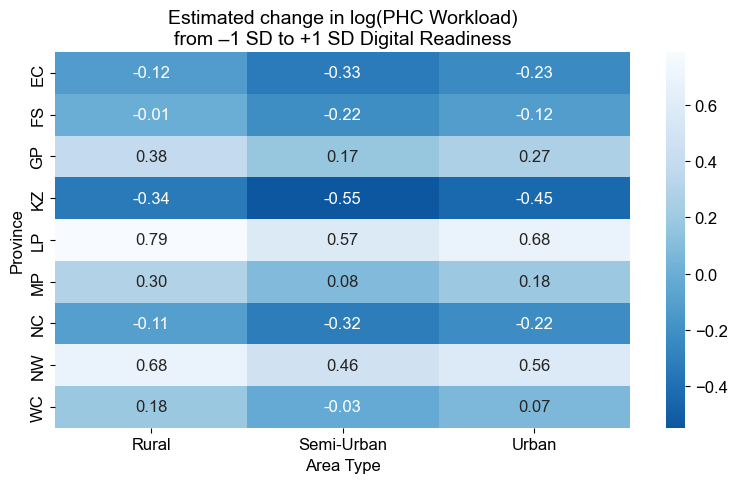

In [115]:
#estimated change in log phc workload from sd change in digital readiness by province and area type

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Values of Digital Readiness for contrast (–1 SD to +1 SD)
dr_low, dr_high = -1.0, 1.0

provinces = sorted(model_df['Province'].dropna().unique().tolist())
area_levels = sorted(model_df['Area_Classification'].dropna().unique().tolist())


rows = []

for prov in provinces:
    re = result.random_effects[prov]   # random intercept + slope for this province
    u0 = re['Group']                   # random intercept
    u1 = re['Digital_Readiness']       # random slope

    for area in area_levels:
        # base covariate profile (all Z = 0, typical year)
        base = {
            'Area_Classification': area,
            'Med_Pracs_per100k': 0.0,
            'PHC_Facilities_Total': 0.0,
            'PHC_Expend_per_capita': 0.0,
            'Household_Size': 0.0,
            'log_Distance_PHC_km': 0.0,
            # Province not needed for fixed part; we handle random effects manually
        }

        # Low DR
        row_low = pd.DataFrame([{**base, 'Digital_Readiness': dr_low}])
        row_low['Area_Classification'] = row_low['Area_Classification'].astype(model_df['Area_Classification'].dtype)
    

        mu_low_fixed = float(result.predict(row_low))     # fixed effects
        mu_low = mu_low_fixed + u0 + u1 * dr_low          # add random intercept + slope

        # High DR
        row_high = pd.DataFrame([{**base, 'Digital_Readiness': dr_high}])
        row_high['Area_Classification'] = row_high['Area_Classification'].astype(model_df['Area_Classification'].dtype)
       

        mu_high_fixed = float(result.predict(row_high))
        mu_high = mu_high_fixed + u0 + u1 * dr_high

        change_log = mu_high - mu_low   # log-scale difference
        rows.append({
            'Province': prov,
            'Area_Classification': area,
            'Change_log': change_log,
            'Change_pct': (np.exp(change_log) - 1) * 100  # optional: % change
        })

out = pd.DataFrame(rows)


pivot = out.pivot(index='Province',
                  columns='Area_Classification',
                  values='Change_log')

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="Blues_r",
    center=0
)
plt.title("Estimated change in log(PHC Workload)\nfrom –1 SD to +1 SD Digital Readiness")
plt.xlabel("Area Type")
plt.ylabel("Province")
plt.tight_layout()
plt.show()



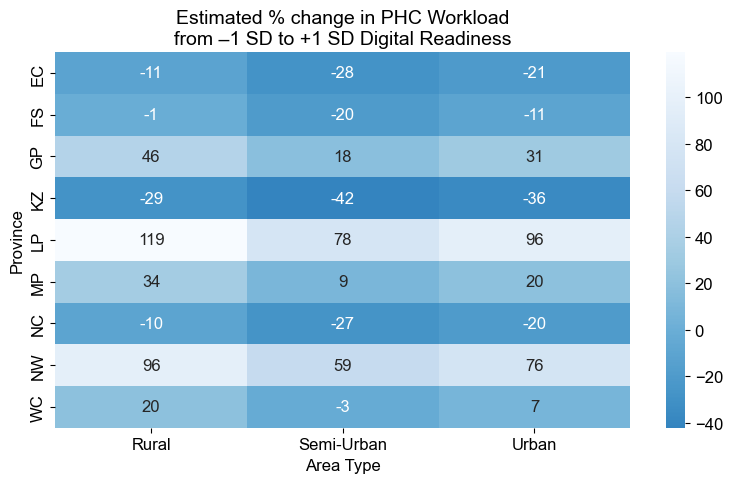

In [116]:
#estimated % change in phc workload from sd change in digital readiness by province and area type - in report

pivot_pct = out.pivot(index='Province',
                      columns='Area_Classification',
                      values='Change_pct')

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_pct,
    annot=True,
    fmt=".0f",
    cmap="Blues_r",
    center=0
)
plt.title("Estimated % change in PHC Workload\nfrom –1 SD to +1 SD Digital Readiness")
plt.xlabel("Area Type")
plt.ylabel("Province")
plt.tight_layout()
plt.show()


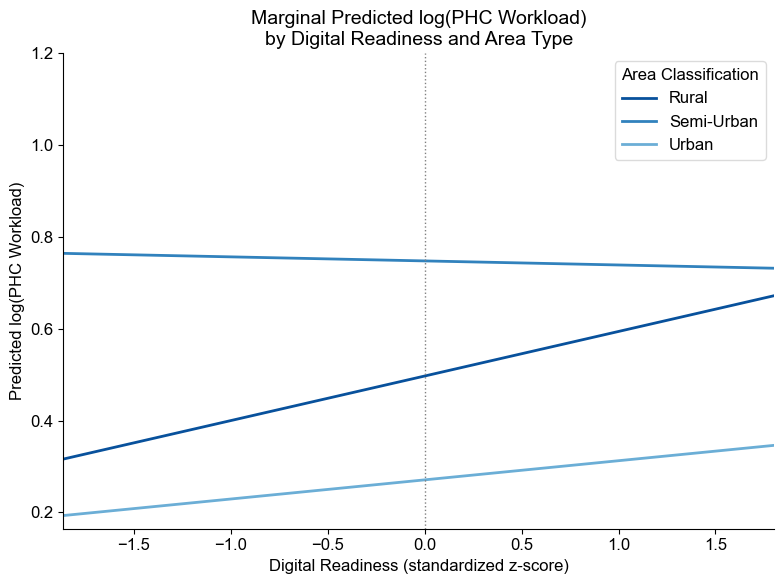

In [117]:
#marginal plots

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# font and style
mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 12,           # base font size for everything
    "axes.titlesize": 14,      # title
    "axes.labelsize": 12,      # x/y labels
    "legend.fontsize": 12,     # legend text
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# blue pallet: darkest = Rural, medium = Semi-Urban, lightest = Urban
area_order = ["Rural", "Semi-Urban", "Urban"]
colors = ["#08519c", "#3182bd", "#6baed6"]

fig, ax = plt.subplots(figsize=(8, 6))

# Make sure x is sorted within each line
for area, col in zip(area_order, colors):
    if area in grid["Area"].unique():
        sub = grid[grid["Area"] == area].sort_values("Digital_Readiness")
        ax.plot(
            sub["Digital_Readiness"],
            sub["Pred_log"],          # or 'Predicted_logWorkload' depending on your grid
            label=area,
            linewidth=2,
            color=col,
        )

# axes

dr_min, dr_max = grid["Digital_Readiness"].min(), grid["Digital_Readiness"].max()
ax.axvline(0, color='grey', linewidth=1, linestyle='dotted')
ax.set_xlim(max(-2, dr_min), min(2, dr_max))


ymin = grid["Pred_log"].min()
ymax = grid["Pred_log"].max()
y_low  = min(0.3, ymin - 0.05*(ymax - ymin))
y_high = max(1.2, ymax + 0.05*(ymax - ymin))
ax.set_ylim(y_low, y_high)

# labels and legend
ax.set_title("Marginal Predicted log(PHC Workload)\nby Digital Readiness and Area Type")
ax.set_xlabel("Digital Readiness (standardized z-score)")
ax.set_ylabel("Predicted log(PHC Workload)")

legend = ax.legend(title="Area Classification", frameon=True)
legend.get_frame().set_edgecolor("lightgrey")

plt.tight_layout()
plt.show()


/var/folders/sx/tjm_f_z14l9g4lrl4d42h0xc0000gp/T/ipykernel_9868/1196731898.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


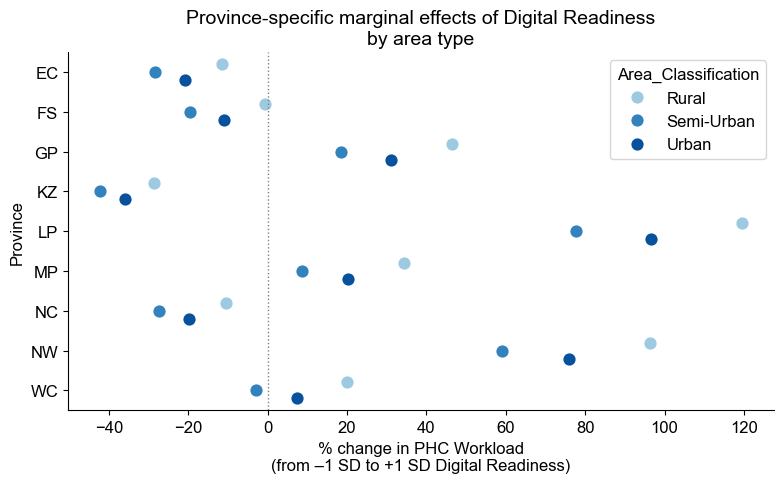

In [118]:
#caterpillar plot of province-specific marginal effects

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=out,
    y='Province',
    x='Change_pct',
    hue='Area_Classification',
    dodge=0.4,
    join=False,
    palette = ['#9ecae1', '#3182bd', '#08519c']
)

plt.axvline(0, color='grey', linewidth=1, linestyle='dotted')

plt.xlabel("% change in PHC Workload\n(from –1 SD to +1 SD Digital Readiness)")
plt.ylabel("Province")
plt.title("Province-specific marginal effects of Digital Readiness\nby area type")
plt.tight_layout()
plt.show()
